In [59]:

# heatmap plot

import pandas as pd
import numpy as np

from pathlib import Path

In [60]:
phosphorylation_scores_path = '/media/kusterlab/internal_projects/active/TOPAS/WP31/Playground/Retrospective_study/2023.06.22_AhS_PAPER_COHORT/protein_results/protein_scores.tsv'
phospho_measure_path = '/media/kusterlab/internal_projects/active/TOPAS/WP31/Playground/Retrospective_study/2023.06.22_AhS_PAPER_COHORT/phospho_measures_z.tsv'
sample_annotation_path = "/media/kusterlab/internal_projects/active/TOPAS/WP31/Searches/patient_annotation_paper_cohort_230626_final.csv"

In [61]:
patients_list = [
                'H021-W3ZFUV-T1-E1',
                'H021-UJBX-M4-Q1',
                'H021-8DSJKN-T1-Q1',
                'H021-3CX96H-T1',
                'H021-M9ZE3G-M1-E1'
                ]
meta_data_path = '/media/kusterlab/internal_projects/active/TOPAS/WP31/Playground/Retrospective_MTBs_Evaluation/Metadata_Papercohort_230801.xlsx'
meta_data = pd.read_excel(meta_data_path)
meta = meta_data[meta_data['Sample name'].isin(patients_list)][['Sample name', 'Paper_pseudo_identifier']].set_index('Sample name').to_dict()['Paper_pseudo_identifier']

In [62]:
ps_scores = pd.read_csv(phosphorylation_scores_path,sep='\t')
phospho_measure = pd.read_csv(phospho_measure_path,sep='\t')

In [63]:
sample_annotation_df = pd.read_csv(sample_annotation_path)
sample_annotation_df = sample_annotation_df[['Sample name','Batch Name']]
new_pep_scores_df = phospho_measure.set_index('Modified sequence')
new_pep_scores_df = new_pep_scores_df.filter(regex='zscore_')
new_pep_scores_df.columns = new_pep_scores_df.columns.str.replace('zscore_','')
new_pep_scores_df =  new_pep_scores_df.T
new_pep_scores_df = new_pep_scores_df.merge(sample_annotation_df,right_on='Sample name',left_index=True)
new_pep_scores_df = new_pep_scores_df.set_index('Batch Name')
def get_num_batch_pep(peptide):
    test = new_pep_scores_df[peptide]
    test = test.dropna()
    ans = 0
    if len(test) > 0:
        ans = len(test.index.unique())
    return ans

In [64]:

protein_of_interest= "EGFR"
def get_phospho_score_and_related_peptides_z_scores(peptides_z_scores_df:pd.DataFrame,
                                         ps_scores_df:pd.DataFrame,
                                         protein_of_interest:str,
                                         patients_list:list)-> pd.DataFrame:
    """ 
    Gets the Phosphorylation scores and peptides z_scores given a protein and list of patients
    
    :peptides_z_scores_df:  phospho_measures_z.tsv
    :ps_scores_df: protein_scores.tsv
    :protein_of_interest: like EGFR
    :patients_list: a list of patients
    """
    ps_scores_df = ps_scores[ps_scores['Gene names'] == protein_of_interest]
    peptides_z_scores_df = phospho_measure[phospho_measure['Gene names'] == protein_of_interest]
    peptides_z_scores_df = peptides_z_scores_df.set_index('Modified sequence')
    ps_scores_df = ps_scores_df.set_index('Gene names')

    peptides_z_scores_df = peptides_z_scores_df.filter(regex='zscore_')
    peptides_z_scores_df.columns = peptides_z_scores_df.columns.str.replace('zscore_','')
    peptides_z_scores_df = peptides_z_scores_df[patients_list]   

    ps_scores_df = ps_scores_df[patients_list]
    if all(ps_scores_df.columns == peptides_z_scores_df.columns):
        final_df = pd.concat([peptides_z_scores_df,ps_scores_df])
    return final_df
 

In [65]:
df = get_phospho_score_and_related_peptides_z_scores(phospho_measure,
                                                    ps_scores,
                                                    protein_of_interest,
                                                    patients_list)


In [66]:
final_pepe_list =  [x for x in df.index.tolist() if x in new_pep_scores_df.columns]
pep_batch_count = list(map(get_num_batch_pep,final_pepe_list))
df_pep_batch = pd.DataFrame(list(zip(final_pepe_list,pep_batch_count)),columns=['peptides_lists','counts'])
df_removing_pep_batch = df_pep_batch['peptides_lists'][df_pep_batch['counts'] <= 1].tolist()
df = df[~df.index.isin(df_removing_pep_batch)]
min_df = df.min().min()
max_df = df.max().max()
df = df.fillna(-4)

In [67]:

df = df.loc[:,patients_list]
df.columns = df.columns.map(meta)

In [ ]:
# adding psite annotations
import psite_annotation as pa
df['Modified sequence'] = df.index
df['Proteins'] = 'P00533'
pa.addPeptideAndPsitePositions(df, pa.pspFastaFile, pspInput = True)
df['Site positions'] = df['Site positions'].str.replace("P00533_",'')
df['Site positions'][-1] = 'EGFR'
df.set_index('Site positions',inplace=True)
columns_to_del = [x for x in df.columns if x in ['protein', 'Proteins', 'Start positions', 'End positions','Modified sequence','Site sequence context']]
df = df.drop(columns=columns_to_del)

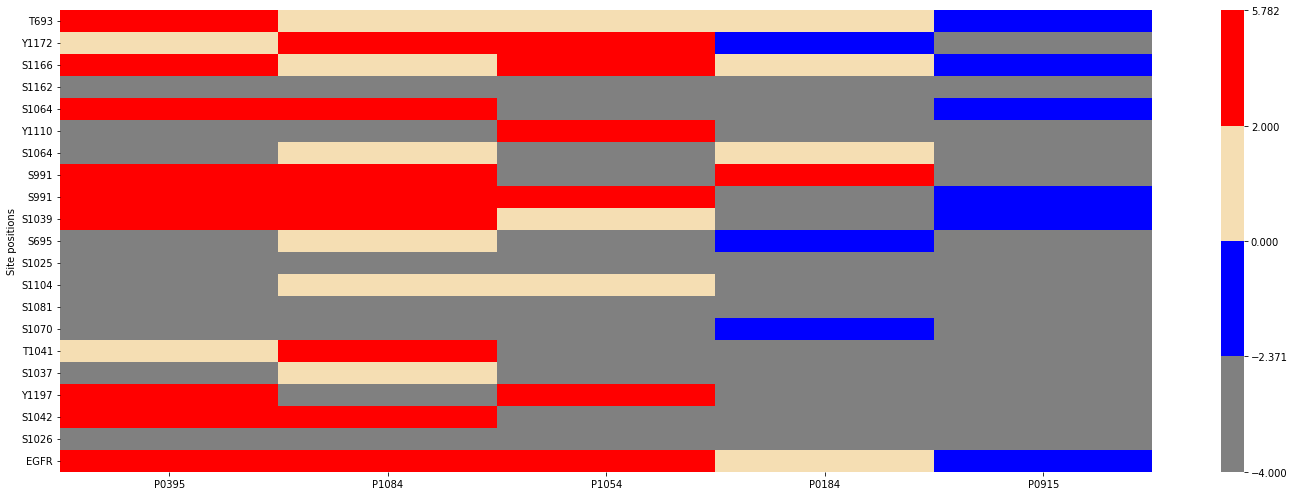

In [79]:
# heatmap
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors
plt.rcParams["figure.figsize"] = [20, 7]
plt.rcParams["figure.autolayout"] = True
cmap = colors.ListedColormap(['grey','blue','wheat','red'])
bounds = [-4,min_df,0,2,max_df]
norm = colors.BoundaryNorm(bounds,cmap.N)
# plot heatmap
sns.heatmap(df,cmap=cmap,norm=norm)

plt.savefig('phosphorylation_scores_heatmap.svg')
plt.show()